## Noisy RGB pixels, Conv + UNet + Residual + Conv + Residual, 1/8 U-Net bottleneck, L1 + L2 + Perceptual + Adversarial Loss

In [1]:
import torch
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


4 (11, 3, 256, 256) float32 (3, 256, 256) float32


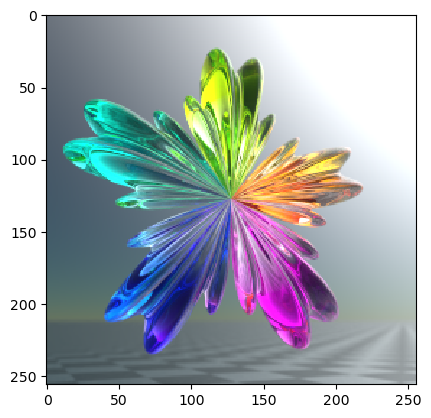

In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()



def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

_ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

torch.Size([8, 3, 256, 256])


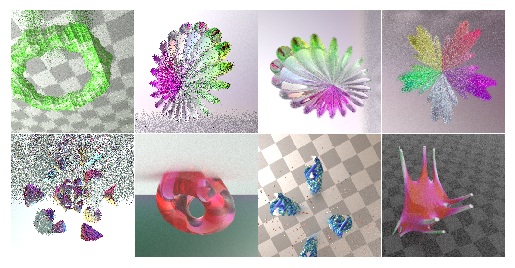

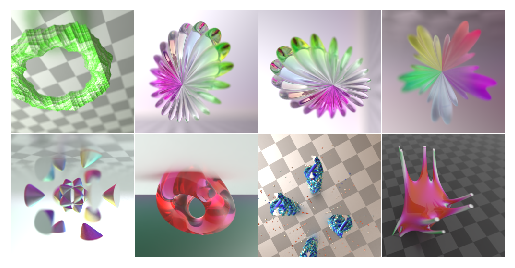

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return 65536

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True)

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def relu(x):
    return F.relu(x, inplace=False)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.econv0a = conv3(n0, n0) # 1
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.econv3b = conv3(n3, n3) # 1/8
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo = conv3(n0, 3)

    def forward(self, input):
        ci = self.convi(input)
        e0 = self.econv0b(relu(self.econv0a(relu(ci)))) # 1
        e1 = self.econv1b(relu(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(relu(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(relu(self.econv3a(pool(e2)))) # 1/8
        d2 = relu(self.dconv2a(relu(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = relu(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = relu(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        return self.convo(ci+do)+input


model = Model().to(device)
print(model)

Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (econv3b): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dconv2a): ConvTranspose2d(32, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv2b): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1))
  (dconv1a): ConvTranspose2d(24, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (dconv1b): Conv2d(32, 16, kernel_size=(1, 1)

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        generated_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, 32)
        target_mapped = torch.nn.functional.avg_pool2d(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, 32)
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.002
)
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, min_lr=0.0, verbose=True)

optimizer_d = torch.optim.Adam(
    discriminator.parameters(),
    lr = 0.002
)

# model 0: 0.2, 1.0, 1.0, 1.0, lr_d=0.0005
# model 1: 0.2, 1.0, 1.0, 0.3, lr_d=0.0005
# model 2: 0.2, 1.0, 1.0, 0.3, lr_d=0.002
# model 3: 0.5, 1.0, 1.0, 0.3, lr_d=0.002
lossfun = CombinedLoss(0.5, 1.0, 1.0, 0.3, device)

/home/harry7557558/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


32 g 4.791564799845219 d 1.4407590813934803
64 g 2.1962329037487507 d 1.436682514846325
96 g 2.1034981422126293 d 1.433393906801939
128 g 1.9448786452412605 d 1.4300661608576775
160 g 1.8375852406024933 d 1.4271114841103554
192 g 1.6835824102163315 d 1.4242112413048744
224 g 1.7032949104905128 d 1.4216560684144497
256 g 1.6438177824020386 d 1.4191787987947464
288 g 1.6586449779570103 d 1.4169914796948433
320 g 1.56873369961977 d 1.4149027056992054
352 g 1.6083145700395107 d 1.4129955358803272
384 g 1.3867034874856472 d 1.411365058273077
416 g 1.4712111670523882 d 1.4097815230488777
448 g 1.3869599550962448 d 1.4079631976783276
480 g 1.3886097557842731 d 1.4070368893444538
512 g 1.3570771552622318 d 1.4055406898260117
544 g 1.3199143316596746 d 1.404447104781866
576 g 1.2210692167282104 d 1.403177224099636
608 g 1.1067255903035402 d 1.4022530429065228
640 g 1.175256760790944 d 1.4015844725072384
672 g 1.1085615158081055 d 1.4007860869169235
704 g 1.1986209750175476 d 1.3999223224818707


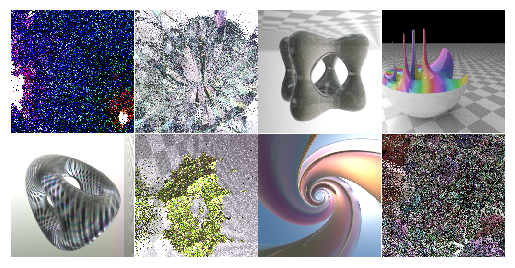

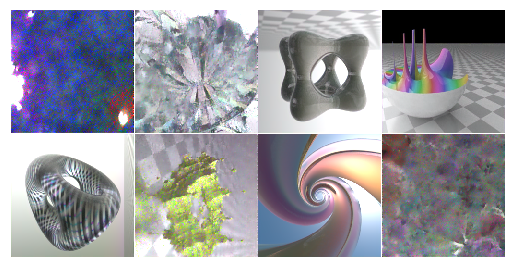

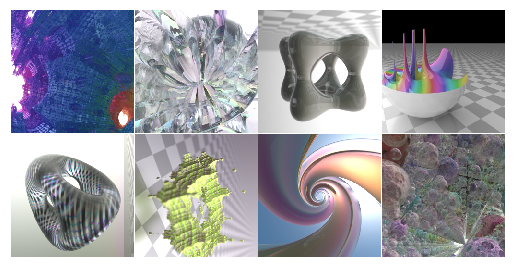

1056 g 1.06546126678586 d 1.3938796520233154
1088 g 1.0128942355513573 d 1.3934662267565727
1120 g 0.9942756202071905 d 1.3931472338736057
1152 g 1.0628549298271537 d 1.392821878194809
1184 g 1.021421791985631 d 1.3927376978099346
1216 g 0.9851037934422493 d 1.3924182429909706
1248 g 1.0326943201944232 d 1.3922066055238247
1280 g 1.0250113140791655 d 1.3919326029717922
1312 g 0.97848398424685 d 1.3918763287365437
1344 g 0.9707980696111917 d 1.3916339166462421
1376 g 1.0372722204774618 d 1.3914558850228786
1408 g 1.0377203691750765 d 1.3911296166479588
1440 g 0.9785140659660101 d 1.390968468040228
1472 g 0.8968065232038498 d 1.3909455314278603
1504 g 1.0246013216674328 d 1.3907450549304485
1536 g 0.9402710534632206 d 1.3906184136867523
1568 g 0.9438595995306969 d 1.390583485364914
1600 g 0.928144933655858 d 1.3902992568910122
1632 g 0.9818621147423983 d 1.3901113010942936
1664 g 0.876217775978148 d 1.3903587684035301
1696 g 0.9741024989634752 d 1.3902405686676502
1728 g 0.88751425966620

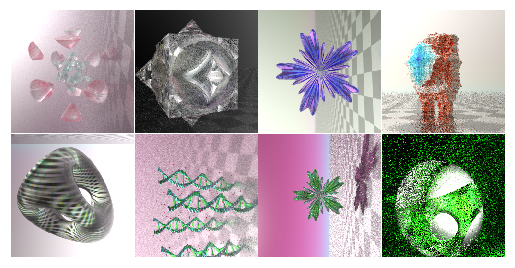

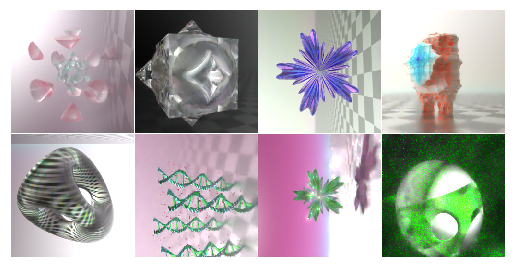

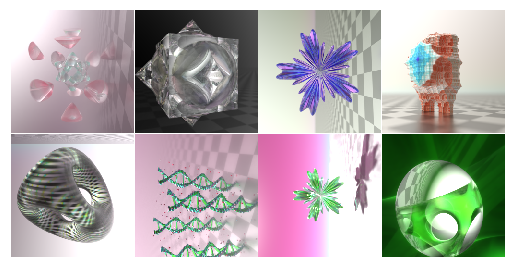

2080 g 0.9408631697297096 d 1.388831440359354
2112 g 0.8850426506251097 d 1.3887932486832142
2144 g 0.8462031409144402 d 1.388815775513649
2176 g 0.904484648257494 d 1.3886567279696465
2208 g 0.8163189552724361 d 1.388573806732893
2240 g 0.9085327349603176 d 1.3884136602282524
2272 g 0.9148416826501489 d 1.3885677866637707
2304 g 0.8752748630940914 d 1.3884689696133137
2336 g 0.8095635240897536 d 1.3883143924176693
2368 g 0.9219131488353014 d 1.388323813676834
2400 g 0.9556449027732015 d 1.3881551325321198
2432 g 0.8474832102656364 d 1.3881779089570045
2464 g 0.9423715155571699 d 1.3880744092166424
2496 g 0.8190763089805841 d 1.3878332003951073
2528 g 0.7975369915366173 d 1.3880517035722733
2560 g 0.8227550126612186 d 1.3880766406655312
2592 g 0.941133102402091 d 1.3880195207893848
2624 g 0.8472317447885871 d 1.3877888023853302
2656 g 0.852870462462306 d 1.387770764529705
2688 g 0.8473134255036712 d 1.387798435986042
2720 g 0.8958752918988466 d 1.3877390660345554
2752 g 0.8416541414335

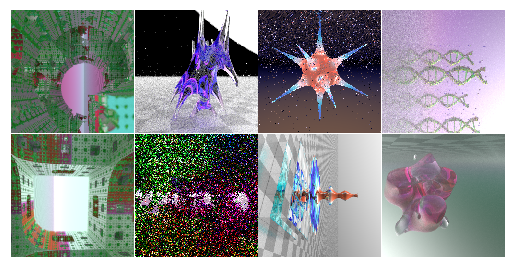

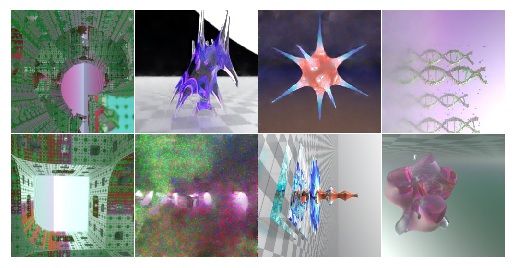

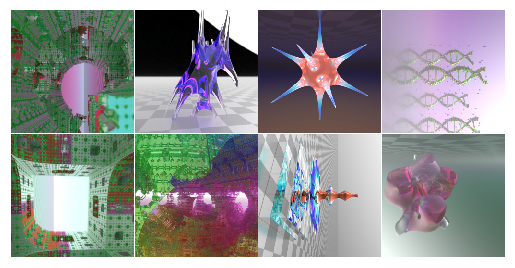

3104 g 0.8273642724379897 d 1.3875755220651627
3136 g 0.8477081255987287 d 1.3873720355331898
3168 g 0.8244012864306569 d 1.387345127761364
3200 g 0.865050689317286 d 1.3875470533967018
3232 g 0.8339634165167809 d 1.3874437734484673
3264 g 0.7621640069410205 d 1.387397587299347
3296 g 0.8450404573231936 d 1.3873248845338821
3328 g 0.8705575633794069 d 1.387314822524786
3360 g 0.8573406096547842 d 1.3870875723659992
3392 g 0.8034298904240131 d 1.387103158980608
3424 g 0.8575976258143783 d 1.3871930427849293
3456 g 0.8617716375738382 d 1.3872210010886192
3488 g 0.8884146315976977 d 1.3860004730522633
3520 g 0.8335951482877135 d 1.3864846117794514
3552 g 0.9115649927407503 d 1.3882822953164577
3584 g 0.7782991928979754 d 1.3871510811150074
3616 g 0.7954540457576513 d 1.3870899006724358
3648 g 0.8576482646167278 d 1.387210886925459
3680 g 0.7877132976427674 d 1.3870785124599934
3712 g 0.806585293263197 d 1.3869219049811363
3744 g 0.8299540467560291 d 1.3871557265520096
3776 g 0.83856948558

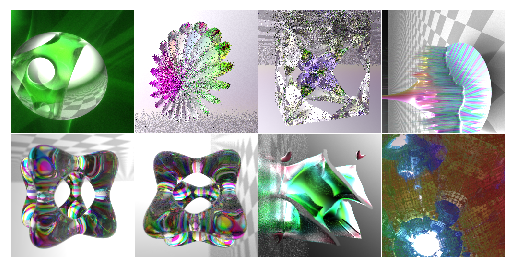

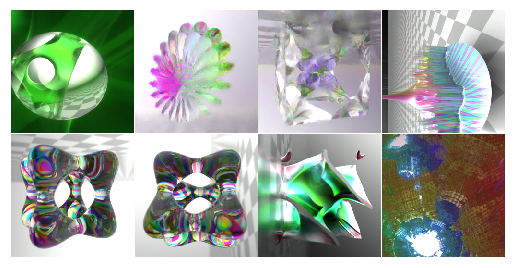

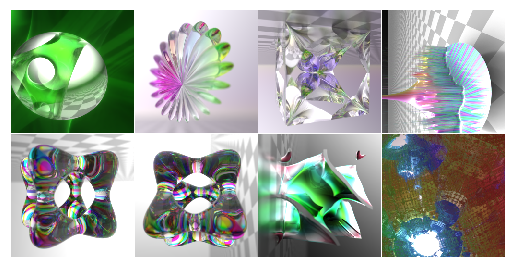

4128 g 0.8901455858722329 d 1.3855733647942543
4160 g 0.787767450325191 d 1.3861813619732857
4192 g 0.7707314677536488 d 1.3865102045238018
4224 g 0.7696219868957996 d 1.3838306367397308
4256 g 0.7850220575928688 d 1.3848236724734306
4288 g 0.8440577257424593 d 1.385714016854763
4320 g 0.8046702155843377 d 1.3869018107652664
4352 g 0.8187639499083161 d 1.3867462277412415
4384 g 0.8300396241247654 d 1.3867930322885513
4416 g 0.6648955754935741 d 1.3870747946202755
4448 g 0.7896161414682865 d 1.386627521365881
4480 g 0.7603715183213353 d 1.385324101895094
4512 g 0.7403282485902309 d 1.3864928670227528
4544 g 0.7281342428177595 d 1.3857842944562435
4576 g 0.8145847599953413 d 1.382882472127676
4608 g 0.7484556138515472 d 1.3860304839909077
4640 g 0.7403725534677505 d 1.3862966261804104
4672 g 0.7947062728926539 d 1.3795815967023373
4704 g 0.8837155159562826 d 1.385564185678959
4736 g 0.8496859380975366 d 1.3858697153627872
4768 g 0.8049304131418467 d 1.3873419165611267
4800 g 0.7773159230

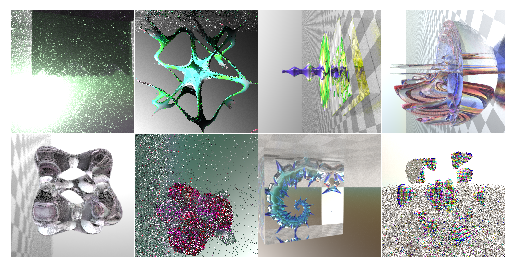

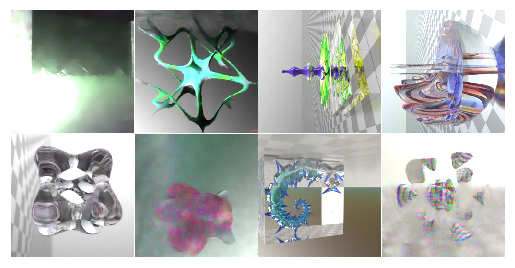

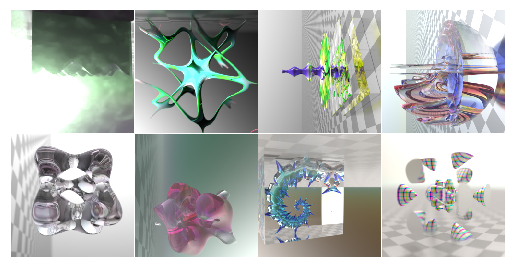

5152 g 0.7998853046447039 d 1.38345605134964
5184 g 0.8052209252491593 d 1.3831711187958717
5216 g 0.8295617001131177 d 1.3872047141194344
5248 g 0.712523752823472 d 1.3867449536919594
5280 g 0.7868568934500217 d 1.3863367773592472
5312 g 0.75378283765167 d 1.3866821378469467
5344 g 0.8398800538852811 d 1.3848982192575932
5376 g 0.7652933085337281 d 1.3833558671176434
5408 g 0.7790951365604997 d 1.3852223865687847
5440 g 0.7442457908764482 d 1.3862798251211643
5472 g 0.7781889904290438 d 1.385972697287798
5504 g 0.6934351734817028 d 1.3869005180895329
5536 g 0.7574764518067241 d 1.3813017345964909
5568 g 0.7604941315948963 d 1.3864691145718098
5600 g 0.7962008211761713 d 1.3837867751717567
5632 g 0.7863019956275821 d 1.3835550583899021
5664 g 0.8038281742483377 d 1.383781798183918
5696 g 0.8016629014164209 d 1.384141318500042
5728 g 0.7478412939235568 d 1.3862827569246292
5760 g 0.7685646209865808 d 1.3857350423932076
5792 g 0.7575659276917577 d 1.3824105560779572
5824 g 0.704197811894

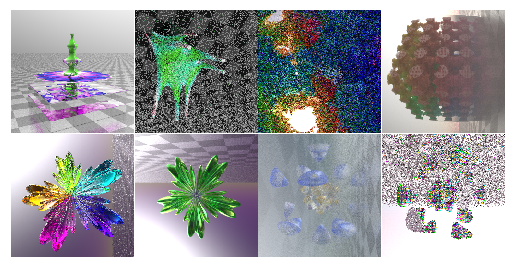

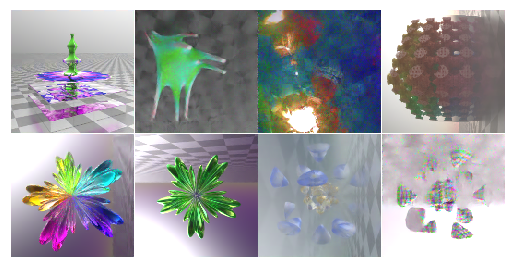

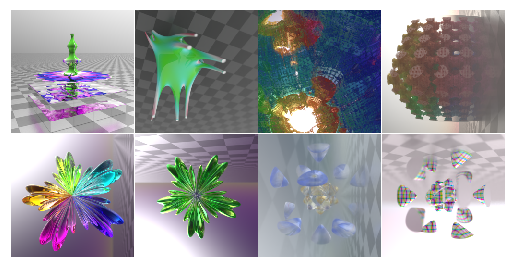

6176 g 0.7373734647408128 d 1.3861975222826004
6208 g 0.7684531072154641 d 1.3863587230443954
6240 g 0.7734937760978937 d 1.3860697969794273
6272 g 0.70070665422827 d 1.3835928328335285
6304 g 0.6928056124597788 d 1.381490208208561
6336 g 0.8462051954120398 d 1.378992523998022
6368 g 0.7144003082066774 d 1.3810586705803871
6400 g 0.7765821879729629 d 1.3730525858700275
6432 g 0.7775250198319554 d 1.3861871473491192
6464 g 0.781753147020936 d 1.375350009649992
6496 g 0.7290066089481115 d 1.3801021464169025
6528 g 0.7772789392620325 d 1.3736412450671196
6560 g 0.7885532509535551 d 1.3812374137341976
6592 g 0.7135985875502229 d 1.3723019622266293
6624 g 0.7954654200002551 d 1.381489098072052
6656 g 0.7113810889422894 d 1.3839499540627003
6688 g 0.7184143867343664 d 1.3769769705832005
6720 g 0.8019822854548693 d 1.3774733804166317
6752 g 0.7226682147011161 d 1.3775874897837639
6784 g 0.7375771049410105 d 1.391935046762228
6816 g 0.7170713897794485 d 1.379271425306797
6848 g 0.6962719596922

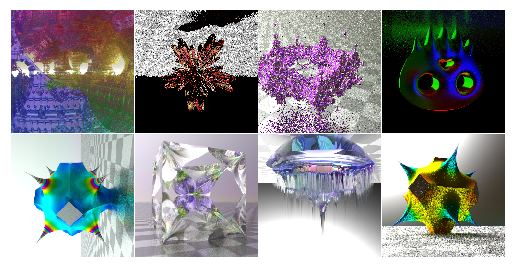

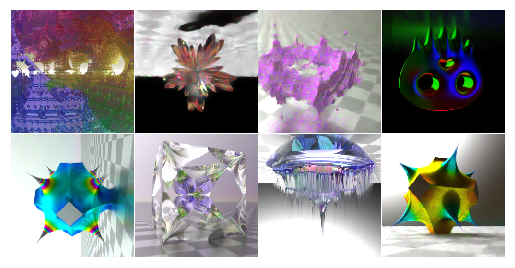

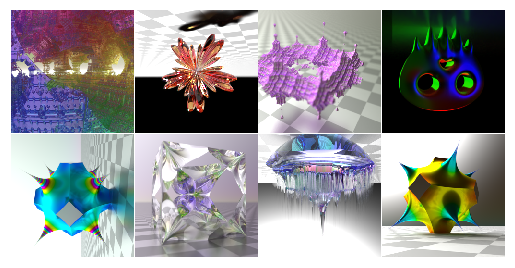

7200 g 0.7765334816649556 d 1.3682054057717323
7232 g 0.7079307064414024 d 1.3658743910491467
7264 g 0.6984885614365339 d 1.370785627514124
7296 g 0.7153195897117257 d 1.3707390688359737
7328 g 0.7567875096574426 d 1.3761604689061642
7360 g 0.756061757914722 d 1.3816629350185394
7392 g 0.7216673288494349 d 1.3803014270961285
7424 g 0.6727364799007773 d 1.369466956704855
7456 g 0.803693656809628 d 1.385660830885172
7488 g 0.7814669786021113 d 1.3643436580896378
7520 g 0.7672865921631455 d 1.3774599768221378
7552 g 0.775918516330421 d 1.3691357374191284
7584 g 0.7317836470901966 d 1.3823059387505054
7616 g 0.7541262255981565 d 1.3820189572870731
7648 g 0.7062410432845354 d 1.3707558885216713
7680 g 0.6989235933870077 d 1.3641301915049553
7712 g 0.766322573646903 d 1.3700969144701958
7744 g 0.7829057108610868 d 1.3665310516953468
7776 g 0.706149147823453 d 1.36711048707366
7808 g 0.7617146344855428 d 1.3612556457519531
7840 g 0.7021481953561306 d 1.3760041519999504
7872 g 0.75095147360116

In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 32
batch_per_epoch = 32
batch_count = 0
terminate = False
mean_loss_g, mean_loss_d = 0.0, 0.0
for epoch in range(4):
    trainloader = torch.utils.data.DataLoader(
        RawDataset(2**17), batch_size=batch_size, shuffle=True)
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        batch_count += 1
        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
        if batch_count % batch_per_epoch == 0:
            print(batch_count, 'g', mean_loss_g, 'd', mean_loss_d)
            scheduler.step(mean_loss_g+mean_loss_d)
            mean_loss_g, mean_loss_d = 0.0, 0.0
            if optimizer.param_groups[0]['lr'] < 0.0001:
                terminate = True
                break
            model_path = "resunet2gan_1.pth"
            torch.save(model, model_path)
        if batch_count % 1024 == 0:
            plot_imgs(torch.exp(x)-1)
            plot_imgs(torch.exp(fake_images.detach())-1)
            plot_imgs(torch.exp(y)-1)
    if terminate:
        break

torch.save(model, model_path)
